# output of new marker files

## based on:
1. cursor direction change
2. peak error
3. ... ?

## how to run:
1. run all cells
2. import the markers (keep old markers!!) in BVA (see history templates)
3. for task B: separate conditions (i.e., occ./not occ.) with advanced boolean expressions

In [3]:
import pandas as pd
import os
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema

In [5]:
%matplotlib notebook

In [4]:
# paths
folder_marker = Path(r"R:\AG-Beste-Studien\Tracking Task\pilot_EEG\export")
path_behav = Path(r"R:\AG-Beste-Studien\Tracking Task\pilot_behav\data")
path_new_marker = Path(r"R:\AG-Beste-Studien\Tracking Task\pilot_EEG\new_behavioral_markers")

In [4]:
# overview of all relevant marker files
all_marker_files = [f for f in os.listdir(folder_marker) if f.endswith(".vmrk")]
marker_files = []
for f in all_marker_files:
    for i in range(7,11):
        if f"Pilot{i}" in f:
            marker_files.append(f)

In [7]:
# overview of all relevant behavioral folders
all_subdirs = [f.name for f in os.scandir(path_behav) if f.is_dir()]
subdirs = []
for d in all_subdirs:
    for i in range(7,11):
        if f"Pilot{i}" in d:
            subdirs.append(d)

In [8]:
def load_trial(foldername, trialnum):
    # trialnum should start at 1
    all_files = os.listdir(path_behav/foldername)
    filename = [f for f in all_files if f.split("_")[-1].split(".")[0] == str(trialnum)][0]
    return pd.read_csv(path_behav/foldername/filename)

In [9]:
# write new markers to file
def write_markers(markers, pilot_num, task):
    f = open(path_new_marker/f"Pilot{pilot_num}_{task}_behavioral_markers.txt", "w")
    f.writelines("Sampling rate: 256Hz, SamplingInterval: 3.90625ms\n")
    f.writelines("Type, Description, Position, Length, Channel\n")
    for m in markers:
        f.writelines(f"Stimulus, S 40, {m}, 1, All\n")
    f.close()

In [10]:
def debug_plot(trial_df, local_max):
    plt.plot(trial_df["traj-x"].tolist(), trial_df["traj-y"].tolist(), "black")
    plt.plot(trial_df["purs-x"].tolist(), trial_df["purs-y"].tolist(), "blue")
    plt.plot(trial_df["purs-x"].tolist(), trial_df["error_abs"].tolist(), "orange")
    plt.vlines([trial_df["traj-x"].tolist()[v] for v in local_max], -0.3, 0.25, "red")
    plt.show()

In [12]:
# integrative function
def deviant_behavior_to_EEG(pilot_num, task):
    # writes new marker file
    
    # 1. load the marker file
    fname = f"Pilot{pilot_num}_{task}_Topographic Interpolation.Markers"
    df = pd.read_csv(folder_marker/fname, skiprows=2, header=None, delimiter=", ")
    
    # 2. derive the start samples and trial durations
    df_starts_ends = df[df[1].isin(["S 27", "S 12", "S 16"])]
    start_trials_samp = []
    dur_trials_in_samp = []
    for i in range(len(df_starts_ends)):
        if i == 0:
            continue
        if df_starts_ends[1].tolist()[i] == "S 27":
            start_trials_samp.append(df_starts_ends[2].tolist()[i])
        elif df_starts_ends[1].tolist()[i - 1] == "S 27":
            dur_trials_in_samp.append(df_starts_ends[2].tolist()[i] - df_starts_ends[2].tolist()[i - 1])
            
    # for all trials, read in the behavioral files
    behavioral_folder = [f for f in subdirs if f.split("-")[0] == fname.split("_")[0]][0]
    
    all_dev_EEG_samples = []
    
    for trial_ind in range(len(dur_trials_in_samp)):
        behav_trial = load_trial(behavioral_folder, trial_ind + 1)
        
        trial_abs_errors = np.array(behav_trial["error_abs"].tolist())
        
        # 1. smooth via LP filter --> 2. identify turning points
        behav_trial["purs-y"]
        
        # derive both indices and values at indices (keep the n largest deviances)
        dev_samples = get_local_min_max(trial_abs_errors)[0]
        dev_samples_vals = get_local_min_max(trial_abs_errors)[1]
        
        # find the cutoff for the trial
        dev_samples_vals_sorted = sorted(dev_samples_vals, reverse=True)
        cutoff_dev = dev_samples_vals_sorted[5]
        
        # only include large deviations (as per the previously identified cutoff)
        dev_samples_perc = []
        dev_samples_abs = []
        for i, lm in enumerate(dev_samples):
            if dev_samples_vals[i] > cutoff_dev:
                dev_samples_perc.append(lm/len(trial_abs_errors))
                dev_samples_abs.append(lm)
        
        #dev_samples_perc = [lm/len(trial_abs_errors) for i, lm in enumerate(dev_samples) if dev_samples_vals[i] > cutoff_dev]
        
        # adjust these values to EEG sample units
        n_samples_EEG_trial = dur_trials_in_samp[trial_ind]
        start_sample_EEG_trial = start_trials_samp[trial_ind]
        EEG_dev_samples_trial = [int(perc*n_samples_EEG_trial) + start_sample_EEG_trial for perc in dev_samples_perc]
        
        # concatenate current trial markers to all new markers
        all_dev_EEG_samples += EEG_dev_samples_trial
        
        # debug plot (adjust as )
        """
        if trial_ind == 1:
            plt.figure()
            debug_plot(behav_trial, dev_samples_abs)
            plt.show()
        #"""
        
    # TODO: bring into file format readable by BVA
    write_markers(all_dev_EEG_samples, pilot_num, task)

In [11]:
for sbj_ind in range(7,11):
    for task in ["A","B","C"]:
        try:
            deviant_behavior_to_EEG(sbj_ind, task)
        except:
            print(f"skipping Pilot{sbj_ind}_{task}")
            continue

<ipython-input-10-3fbc72817f82>:7: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  df = pd.read_csv(folder_marker/fname, skiprows=2, header=None, delimiter=", ")


skipping Pilot7_A


playground

In [11]:
pilot_num = 10
task = "A"

# writes new marker file
    
# 1. load the marker file
fname = f"Pilot{pilot_num}_{task}_Topographic Interpolation.Markers"
df = pd.read_csv(folder_marker/fname, skiprows=2, header=None, delimiter=", ")

# 2. derive the start samples and trial durations
df_starts_ends = df[df[1].isin(["S 27", "S 12", "S 16"])]
start_trials_samp = []
dur_trials_in_samp = []
for i in range(len(df_starts_ends)):
    if i == 0:
        continue
    if df_starts_ends[1].tolist()[i] == "S 27":
        start_trials_samp.append(df_starts_ends[2].tolist()[i])
    elif df_starts_ends[1].tolist()[i - 1] == "S 27":
        dur_trials_in_samp.append(df_starts_ends[2].tolist()[i] - df_starts_ends[2].tolist()[i - 1])

# for all trials, read in the behavioral files
behavioral_folder = [f for f in subdirs if f.split("-")[0] == fname.split("_")[0]][0]

all_dev_EEG_samples = []

for trial_ind in range(len(dur_trials_in_samp)):
    behav_trial = load_trial(behavioral_folder, trial_ind + 1)

    trial_abs_errors = np.array(behav_trial["error_abs"].tolist())

    # 1. smooth via LP filter --> 2. identify turning points
    behav_trial["purs-y"]

    # derive both indices and values at indices (keep the n largest deviances)
    dev_samples = get_local_min_max(trial_abs_errors)[0]
    dev_samples_vals = get_local_min_max(trial_abs_errors)[1]

    # find the cutoff for the trial
    dev_samples_vals_sorted = sorted(dev_samples_vals, reverse=True)
    cutoff_dev = dev_samples_vals_sorted[5]

    # only include large deviations (as per the previously identified cutoff)
    dev_samples_perc = []
    dev_samples_abs = []
    for i, lm in enumerate(dev_samples):
        if dev_samples_vals[i] > cutoff_dev:
            dev_samples_perc.append(lm/len(trial_abs_errors))
            dev_samples_abs.append(lm)

    #dev_samples_perc = [lm/len(trial_abs_errors) for i, lm in enumerate(dev_samples) if dev_samples_vals[i] > cutoff_dev]

    # adjust these values to EEG sample units
    n_samples_EEG_trial = dur_trials_in_samp[trial_ind]
    start_sample_EEG_trial = start_trials_samp[trial_ind]
    EEG_dev_samples_trial = [int(perc*n_samples_EEG_trial) + start_sample_EEG_trial for perc in dev_samples_perc]

    # concatenate current trial markers to all new markers
    all_dev_EEG_samples += EEG_dev_samples_trial

    # debug plot (adjust as )
    """
    if trial_ind == 1:
        plt.figure()
        debug_plot(behav_trial, dev_samples_abs)
        plt.show()
    #"""

# TODO: bring into file format readable by BVA
write_markers(all_dev_EEG_samples, pilot_num, task)

C:\Program Files\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


NameError: name 'get_local_min_max' is not defined

<IPython.core.display.Javascript object>


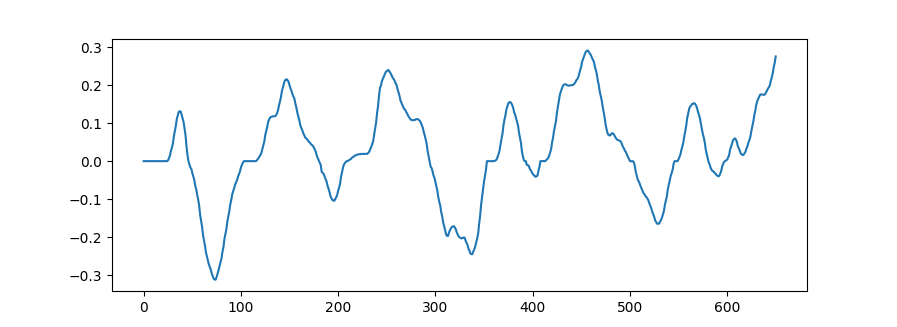

In [20]:
plt.plot(behav_trial["purs-y"])

In [12]:
import scipy

In [13]:
behav_trial["purs-x"]

0      0.000000
1     -0.001040
2     -0.002028
3     -0.002962
4     -0.003853
5     -0.004712
6     -0.005546
7     -0.006359
8     -0.007153
9     -0.007933
10    -0.008706
11    -0.009473
12    -0.010235
13    -0.010998
14    -0.011764
15    -0.012533
16    -0.013314
17    -0.014107
18    -0.014916
19    -0.015745
20    -0.016602
21    -0.017499
22    -0.018441
23    -0.019444
24    -0.020530
25    -0.021732
26    -0.023132
27    -0.024872
28    -0.027475
29    -0.030768
         ...   
756   -0.735588
757   -0.736961
758   -0.738644
759   -0.741205
760   -0.744385
761   -0.746291
762   -0.747660
763   -0.748773
764   -0.749729
765   -0.750584
766   -0.751371
767   -0.752108
768   -0.752781
769   -0.753428
770   -0.754048
771   -0.754632
772   -0.755208
773   -0.755749
774   -0.756287
775   -0.756798
776   -0.757308
777   -0.757795
778   -0.758283
779   -0.758752
780   -0.759219
781   -0.759676
782   -0.760128
783   -0.760576
784   -0.761017
785   -0.761458
Name: purs-x, Length: 78

In [16]:
# derive filter
# 1 Hz is eyeballed
sos = scipy.signal.iirfilter(2, 0.1, btype='lowpass', output='sos')
filtered_signal = scipy.signal.sosfilt(sos, behav_trial["purs-y"].tolist())

In [70]:
def get_local_min_max(one_dim_list, min_samp_dist = 5, only_max=True):
    # returns percentages
    
    local_max = []
    local_max_vals = []
    ascending = False
    ascend_counter = 0
    descend_counter = 0
    
    if not only_max:
        local_min = []
        local_min_vals = []
        descending = False
        ascend_counter_min = 0
        descend_counter_min = 0

    for i, val in enumerate(one_dim_list[:-1]):

        # if ascending and previously descending, reset counter
        if one_dim_list[i + 1] > one_dim_list[i] and not ascending:
            #debug: set ascend_counter to 1 if first ascending value
            ascend_counter = 1
            
            ascending = True
            
        # if ascending already true, increment counter
        elif one_dim_list[i + 1] > one_dim_list[i]:
            ascend_counter += 1

        # if descending and previously ascending, reset counter
        if one_dim_list[i + 1] < one_dim_list[i] and ascending:
            ascending = False
            
            #debug: set descend_counter to 1 if first descending value
            descend_counter = 1
            
            # "lose" the progress if not minimum number of ascends --> reset ascend_counter
            if ascend_counter < min_samp_dist:
                ascend_counter = 1
                
        # if descending already true, increment counter
        # but only if it is a viable candidate
        elif one_dim_list[i + 1] < one_dim_list[i]:
            descend_counter += 1

        # check descending
        if ascend_counter >= min_samp_dist and descend_counter >= min_samp_dist:
            local_max.append(i - descend_counter)
            local_max_vals.append(one_dim_list[i - descend_counter])
            print("ascend counter resetted at i = ")
            print(i)
            print("descend counter at:")
            print(descend_counter)
            ascend_counter = 1
            #descend_counter = 1
        elif ascending:
            descend_counter = 1
        
        if not only_max:
            
            # if descending and previously ascending, reset counter
            if one_dim_list[i + 1] < one_dim_list[i] and not descending:
                
                #debug
                descend_counter = 1
                
                descending = True
            # if descending already true, increment counter
            elif one_dim_list[i + 1] < one_dim_list[i]:
                descend_counter_min += 1

            # if ascending and previously descending, reset counter
            if one_dim_list[i + 1] > one_dim_list[i] and descending:
                descending = False
                
                #debug
                ascend_counter_min = 1
                
                # "lose" the progress if not minimum number of descends --> reset
                if descend_counter_min < min_samp_dist:
                    descend_counter_min = 1
            # if ascending already true, increment counter
            # but only if it is a viable candidate
            elif one_dim_list[i + 1] > one_dim_list[i]:
                ascend_counter_min += 1

            # check ascending
            if descend_counter_min >= min_samp_dist and ascend_counter_min >= min_samp_dist:
                local_min.append(i - ascend_counter_min)
                local_min_vals.append(one_dim_list[i - ascend_counter_min])
                print("descend counter resetted at i = ")
                print(i)
                print("ascend counter at:")
                print(ascend_counter_min)
                descend_counter_min = 1
                #ascend_counter_min = 1
            elif descending:
                ascend_counter_min = 1
                
    if not only_max:
        print(local_min, local_max)
        return [local_max+local_min, local_max_vals+local_min_vals]
    
    return [local_max, local_max_vals] #[lm/len(one_dim_list) for lm in local_max]

<IPython.core.display.Javascript object>


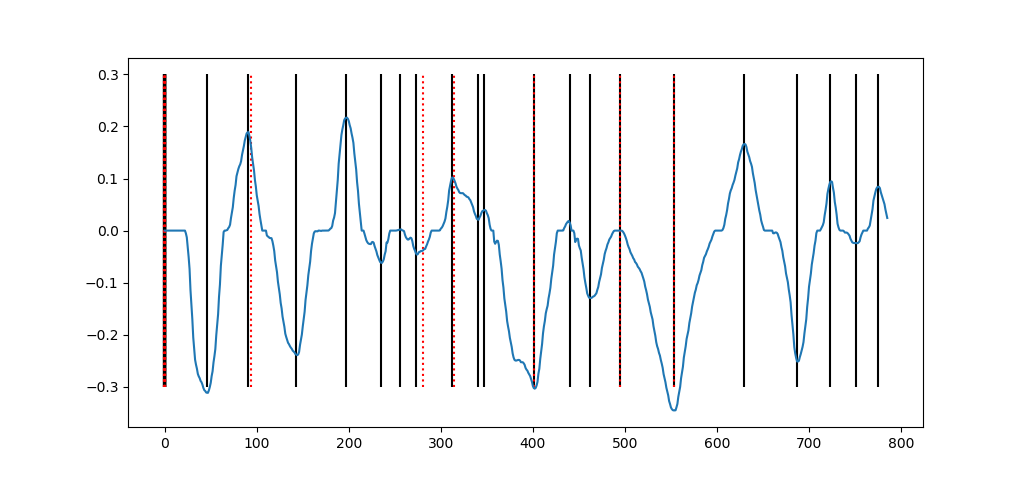

descend counter resetted at i = 
51
ascend counter at:
5
ascend counter resetted at i = 
95
descend counter at:
5
descend counter resetted at i = 
148
ascend counter at:
5
ascend counter resetted at i = 
202
descend counter at:
5
descend counter resetted at i = 
240
ascend counter at:
5
ascend counter resetted at i = 
261
descend counter at:
5
descend counter resetted at i = 
278
ascend counter at:
5
ascend counter resetted at i = 
317
descend counter at:
5
descend counter resetted at i = 
345
ascend counter at:
5
ascend counter resetted at i = 
352
descend counter at:
5
descend counter resetted at i = 
406
ascend counter at:
5
ascend counter resetted at i = 
445
descend counter at:
5
descend counter resetted at i = 
467
ascend counter at:
5
ascend counter resetted at i = 
500
descend counter at:
5
descend counter resetted at i = 
558
ascend counter at:
5
ascend counter resetted at i = 
634
descend counter at:
5
descend counter resetted at i = 
692
ascend counter at:
5
ascend counter r

In [71]:
plt.figure()
plt.plot(behav_trial["purs-y"])
plt.vlines(get_local_min_max(behav_trial["purs-y"], 5,  False), -0.3, 0.3)
plt.vlines(get_local_min_max(behav_trial["purs-y"], 25,  False), -0.3, 0.3, colors = 'r', linestyles = 'dotted')
#plt.plot(filtered_signal)
plt.show()

In [ ]:
def new_improved_max_min(one_dim_list):
    